In [181]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import scipy.stats as ss
from scipy.stats import norm

# Starting with Anomaly detection on weekly data

### Assemble stock data from yahoo finance

In [148]:
stocks = ['META', 'MSFT', 'XOM', '^GSPC'] # Meta, Microsoft, Exxon Mobil, S&P500 index

start_date = '2013-01-01' # META is missing data before May 2012, no NAs after
end_date = '2024-12-31'
data = yf.download(stocks, start=start_date, end=end_date)


[*********************100%***********************]  4 of 4 completed


In [149]:
# COlumn structure, and confirm no NAs
data.isna().sum()

Price   Ticker
Close   META      0
        MSFT      0
        XOM       0
        ^GSPC     0
High    META      0
        MSFT      0
        XOM       0
        ^GSPC     0
Low     META      0
        MSFT      0
        XOM       0
        ^GSPC     0
Open    META      0
        MSFT      0
        XOM       0
        ^GSPC     0
Volume  META      0
        MSFT      0
        XOM       0
        ^GSPC     0
dtype: int64

### Preprocessing of stock data
- For the given daily stock data, we will smooth it using moving average over 5 days, then make it weekly.
- Then we will log-transform the data and use the change for each week
- We will further standardize the log-transformed changes so that we can compare across the symbols as well
- Lastly we will visualize the normality and outliers using histograms and Q-Q plots to see if the log-transformed changes are appropriate to use for further analysis


In [292]:
# Apply rolling average over 5 days centered at each day
data_smooth = data.rolling(window=5, min_periods=1).mean()

# Resample to weekly and aggregate by mean
weekly_df = data_smooth.resample('W').mean().iloc[1:-1]

# Using log-transformed changes
log_changes = np.log(weekly_df / weekly_df.shift(1)).dropna()
# Standardize
log_changes = (log_changes - log_changes.mean())/log_changes.std()

Visualizing the distribution of log changes (first overall, then year-wise)

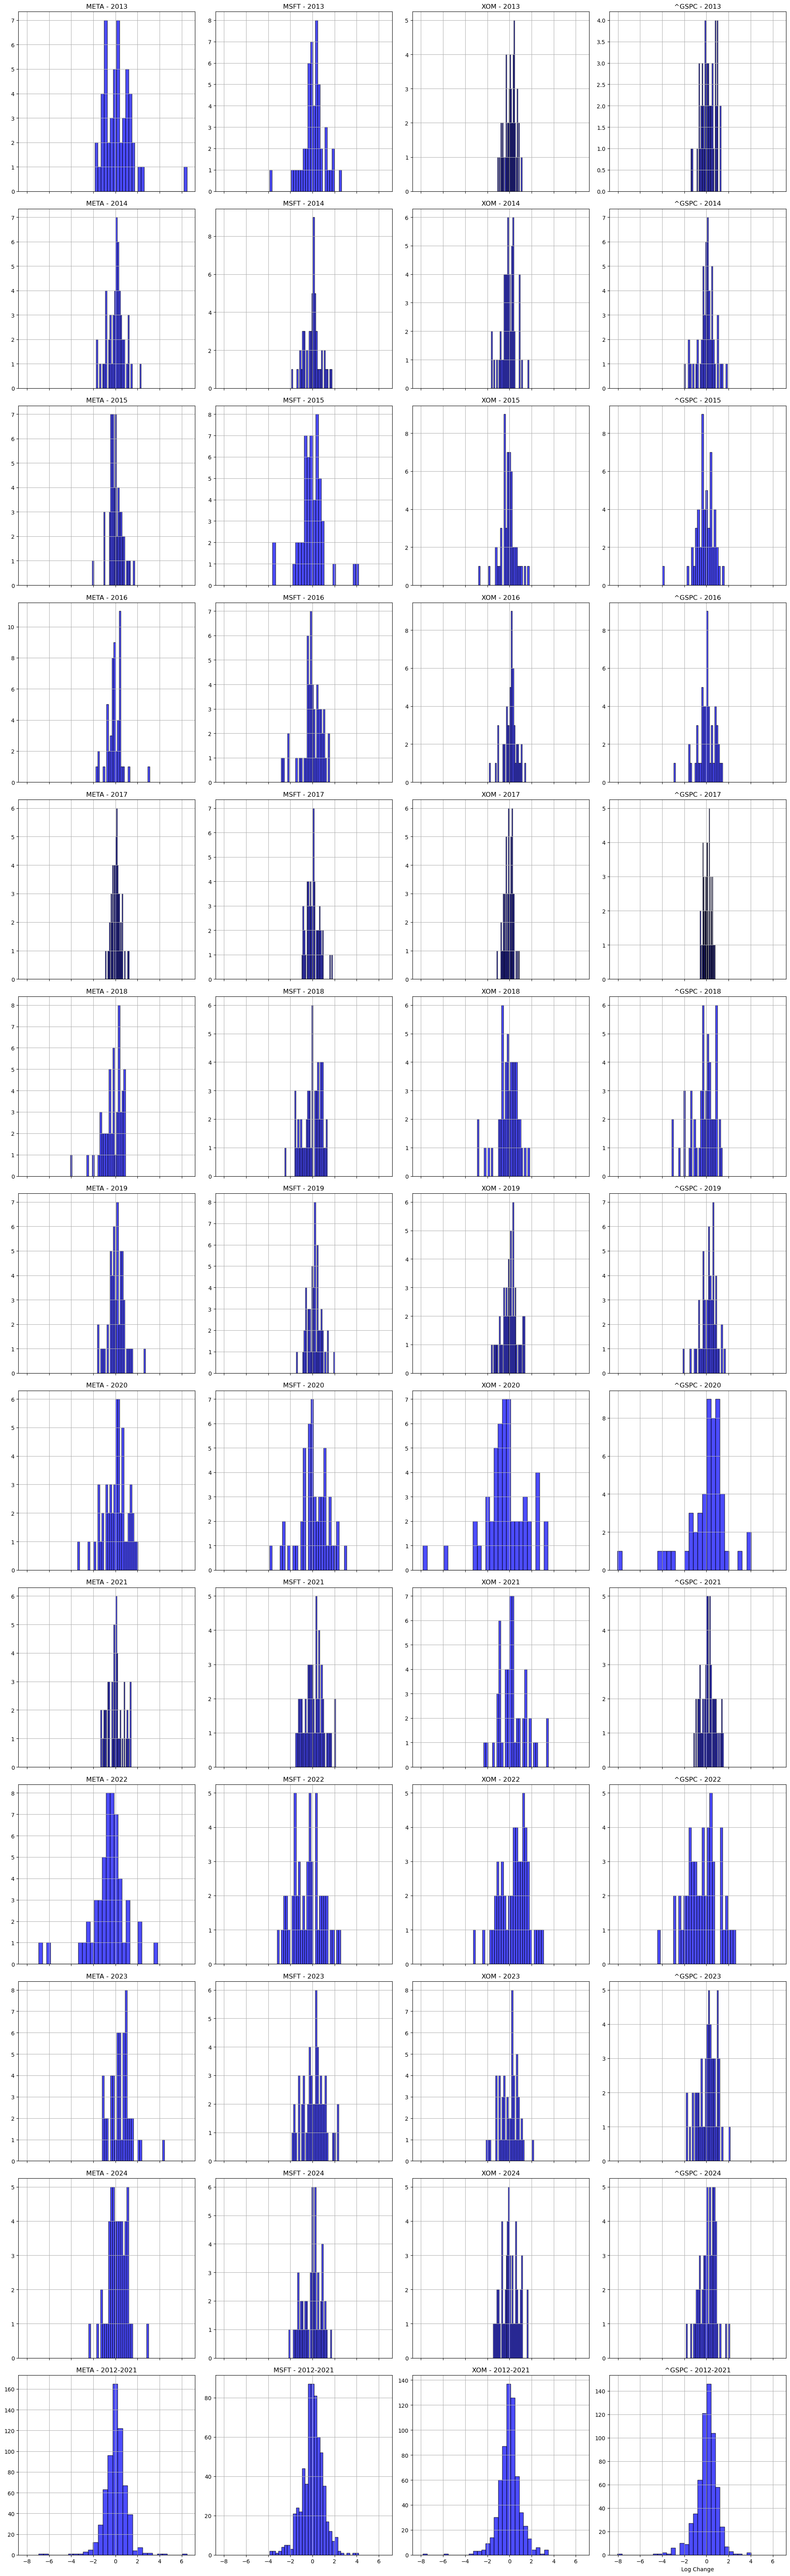

In [293]:
years = log_changes.index.year.unique()
Ny = len(years)
symbols = log_changes["Close"].columns

fig, axes = plt.subplots(Ny+1, len(symbols), figsize=(20, 5 * (Ny+1)), sharex=True)

for j, symbol in enumerate(symbols):
    for i, year in enumerate(years):
        ax = axes[i, j]
        yearly_data = log_changes["Close"].loc[str(year), symbol].dropna()

        ax.hist(yearly_data, bins=30, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(f"{symbol} - {year}")
        ax.grid(True)
        # Plot for all years 2012-2021
    ax = axes[Ny, j]
    all_data = log_changes["Close"].loc[:, symbol].dropna()

    ax.hist(all_data, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f"{symbol} - 2012-2021")
    ax.grid(True)

plt.xlabel("Log Change")
plt.tight_layout()
plt.show()

Log-transformed changes look mostly unimodal (except for 2020, the year of pandemic shutdown) but it could be heavy-tailed
Checking distribution of log-transformed changes through q-q plots

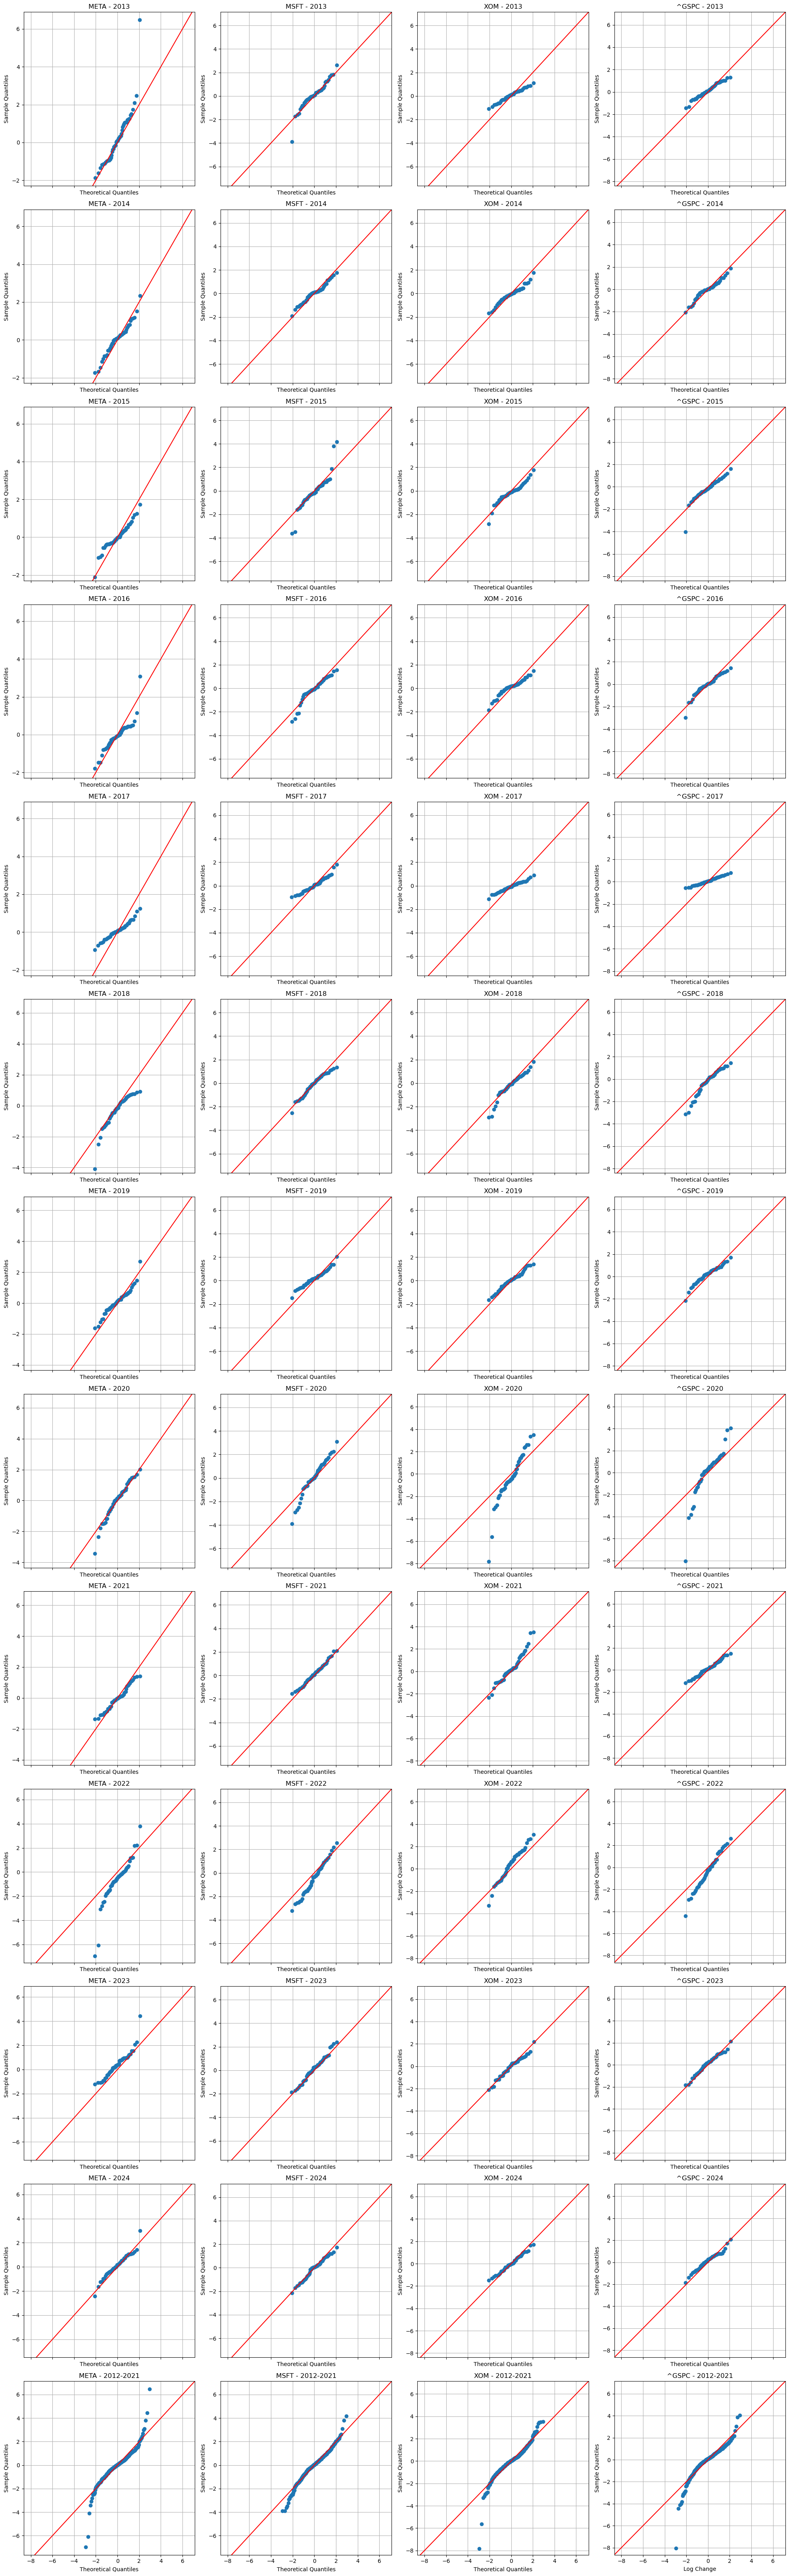

In [294]:
years = log_changes.index.year.unique()
Ny = len(years)
symbols = log_changes["Close"].columns

fig, axes = plt.subplots(Ny+1, len(symbols), figsize=(20, 5 * (Ny+1)), sharex=True)

for j, symbol in enumerate(symbols):
    for i, year in enumerate(years):
        ax = axes[i, j]
        yearly_data = log_changes["Close"].loc[str(year), symbol].dropna()

        sm.qqplot(yearly_data, line='45', ax = ax)
        ax.set_title(f"{symbol} - {year}")
        ax.grid(True)

    # Plot for all years 2012-2021
    ax = axes[Ny, j]
    all_data = log_changes["Close"].loc[:, symbol].dropna()

    sm.qqplot(all_data, line='45', ax = ax)
    ax.set_title(f"{symbol} - 2012-2021")
    ax.grid(True)


# Set labels
plt.xlabel("Log Change")
plt.tight_layout()
plt.show()

In [295]:
dist = getattr(ss,'norm')

In [296]:
norm.cdf(-2)

np.float64(0.022750131948179198)

In [297]:
norm.ppf(0.25)

np.float64(-0.6744897501960817)

Q-Q plots of the log changes in closing price (averaged weekly) for each stock for each year as well as all years combined (in the last row).

Q-Q plots lie mostly on the diagonal, except for some years such as 2020 (the year of oandemic shutdown). However, the plots deviate from the diagonal near the extreme ends. Thus, we have heavy-tailed distribution.

Thus, it will be interesting to discover such anomolous periods, and connect with the real-world events.

Since we are interested in the the outlier events, we can make a background normal distribution using the median of the observed data as mean and setting the standard deviation such that interquantile range matches the observed one.

In [298]:
# IQR range
IQRs = np.array([np.percentile(log_changes["Close"].loc[:,t], 75) - np.percentile(log_changes["Close"].loc[:,t], 25) for t in symbols])
for t,std in zip(symbols,np.round(IQRs,3)):
    print(t,std)

META 0.935
MSFT 1.066
XOM 0.929
^GSPC 0.965


Since IQR of standard normal is $ 1.349\sigma $, we use the $\sigma$ of our background normal distribution to be IQR / 1.349.
Since log chages were standardized, we will use 0 as mean for the background.

In [307]:
bg_std = dict(zip(symbols,IQRs / 1.349))
bg_mean = {t:log_changes["Close"].loc[:,t].median() for t in symbols}
for t in symbols:
    print(t)
    print("Background mean (based on on IQR) = ", np.round(bg_mean[t],3))
    print("Background std. (based on on IQR) = ", np.round(bg_std[t],3))


META
Background mean (based on on IQR) =  0.02
Background std. (based on on IQR) =  0.693
MSFT
Background mean (based on on IQR) =  0.047
Background std. (based on on IQR) =  0.79
XOM
Background mean (based on on IQR) =  0.031
Background std. (based on on IQR) =  0.689
^GSPC
Background mean (based on on IQR) =  0.08
Background std. (based on on IQR) =  0.715


In [391]:
ss.norm.cdf(-3)*2

np.float64(0.002699796063260186)

In [394]:
ss.norm.ppf(0.025)

np.float64(-1.9599639845400545)

In [429]:
def BH_cutoff(pvals,alpha):
    pvals = np.sort(pvals)
    meet_crit = pvals<np.arange(1,len(pvals)+1)/len(pvals)*alpha
    if meet_crit.sum()==0:
        return 0
    return pvals[np.ravel(np.argwhere(meet_crit))[-1]]
    
# BH_cutoff([0.05/6,0.06/6,0.07/6,0.01/6,0.03/6],0.05)

<Figure size 640x480 with 0 Axes>

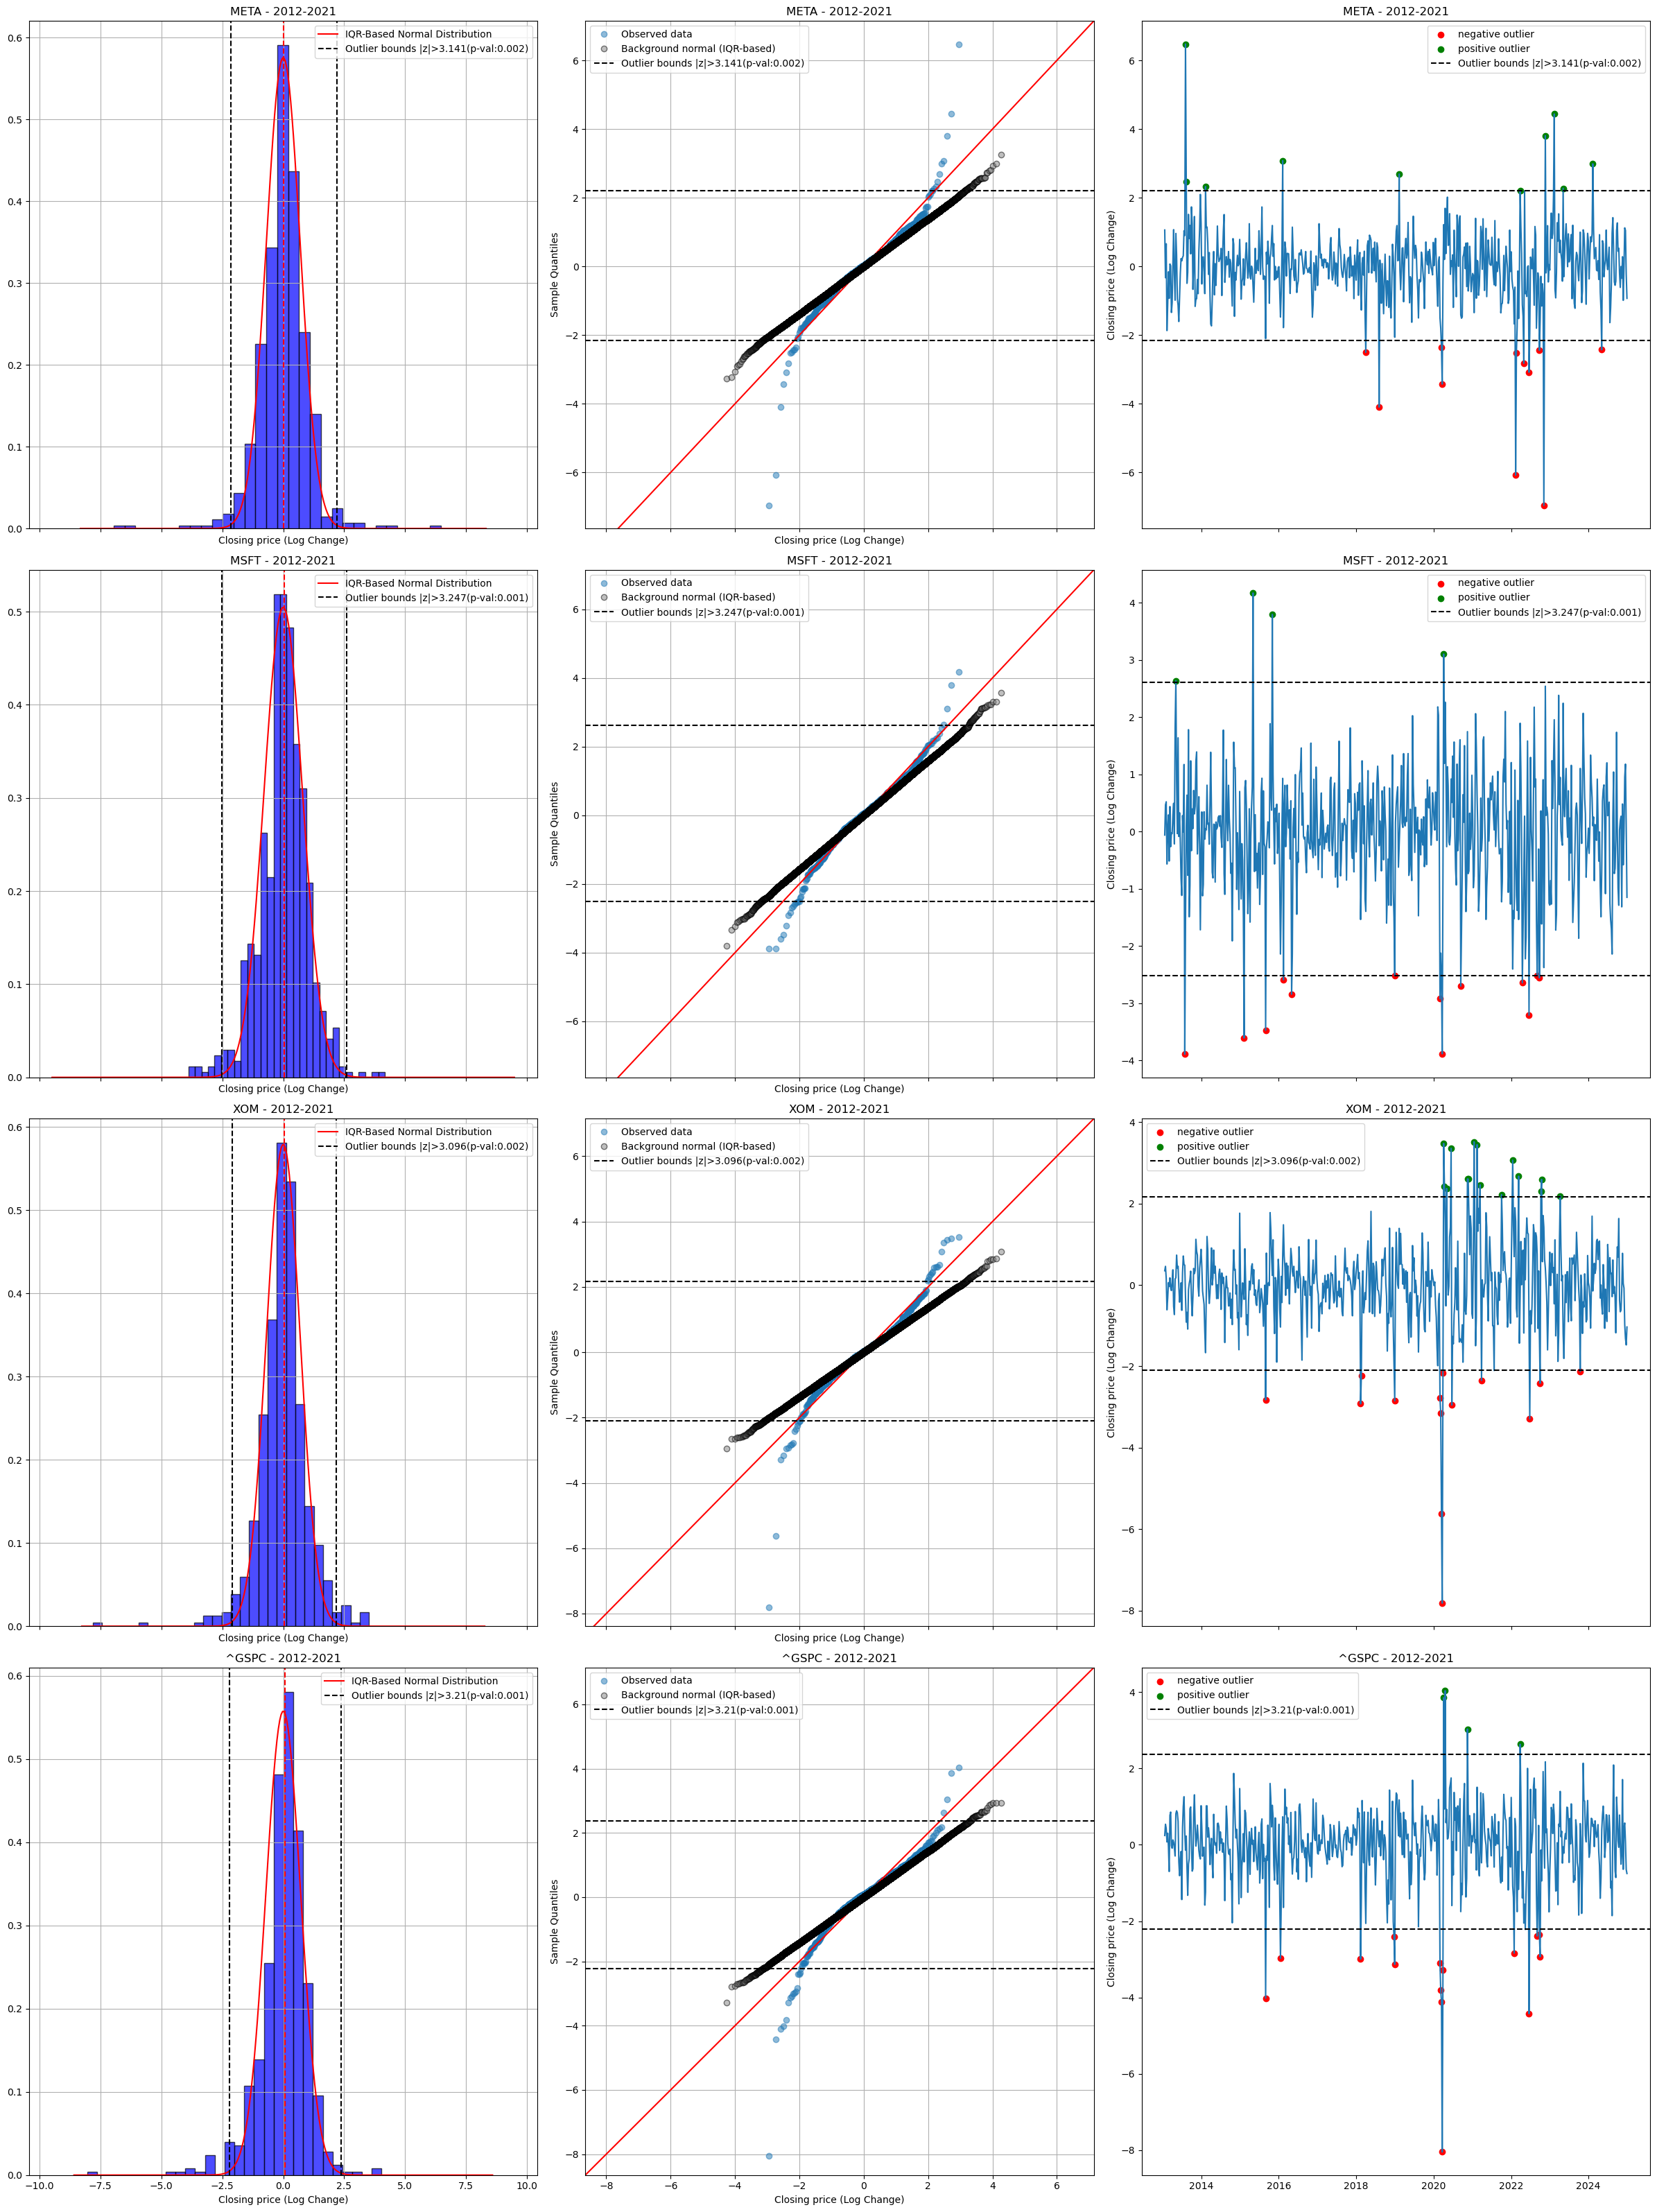

In [430]:
pval_thr = 0.05
low_anomalies = dict()
high_anomalies = dict()
plt.clf()
fig, axes = plt.subplots(len(symbols),3, figsize=(8*3, 4*8), sharex = 'col')

for j,t in enumerate(symbols):
    # make background dist
    mean = bg_mean[t]
    std = bg_std[t]
    x = np.linspace(-12*std,12*std, 300)
    pdf = ss.norm.pdf(x, loc=0, scale=std)

    # finding anomalies
    z_scores = (log_changes["Close"].loc[:,t] - mean) / std
    pvals = ss.norm.cdf(-np.abs(z_scores))*2
    z_thr = np.abs(ss.norm.ppf(BH_cutoff(pvals,pval_thr)/2))
    low_anomalies[t] = z_scores < -z_thr
    high_anomalies[t] = z_scores > z_thr
    

    # plot observed and background dist
    ax = axes[j][0]
    ax.hist(log_changes["Close"].loc[:,t], bins=30, alpha=0.7, color='blue', edgecolor='black', density=True)
    ax.plot(x, pdf, 'r-', label="IQR-Based Normal Distribution")
    ax.axvline(mean, color='r', linestyle="--")
    ax.axvline(z_thr*std + mean, color='k', linestyle="--", label=f"Outlier bounds |z|>{np.round(z_thr,3)}(p-val:{np.round(ss.norm.cdf(-np.abs(z_thr))*2,3)})")
    ax.axvline(-z_thr*std + mean, color='k', linestyle="--")
    ax.set_title(f"{t} - 2012-2021")
    ax.grid(True)
    ax.set_xlabel("Closing price (Log Change)")
    ax.legend()

    ## qqplot of same
    ax = axes[j][1]
    sm.qqplot(log_changes["Close"].loc[:,t], line='45', ax = ax, alpha = 0.5, label = "Observed data")
    sm.qqplot(np.random.normal(loc=0, scale=std, size=100000), ax = ax, alpha = 0.5, label = "Background normal (IQR-based)", markerfacecolor='gray', markeredgecolor='black')
    ax.axhline(-z_thr*std + mean, color='k', linestyle="--", label=f"Outlier bounds |z|>{np.round(z_thr,3)}(p-val:{np.round(ss.norm.cdf(-np.abs(z_thr))*2,3)})")
    ax.axhline(z_thr*std + mean, color='k', linestyle="--")
    ax.set_title(f"{t} - 2012-2021")
    ax.grid(True)
    ax.set_xlabel("Closing price (Log Change)")
    ax.legend()
    
    # plot anomalies on actual prices
    ax = axes[j][2]
    ax.plot(log_changes.index,log_changes["Close"].loc[:,t])
    ax.scatter(log_changes.index[low_anomalies[t]],log_changes["Close"].loc[low_anomalies[t],t], color = "red",label = "negative outlier")
    ax.scatter(log_changes.index[high_anomalies[t]],log_changes["Close"].loc[high_anomalies[t],t], color = "green",label = "positive outlier")
    ax.axhline(-z_thr*std + mean, color='k', linestyle="--", label=f"Outlier bounds |z|>{np.round(z_thr,3)}(p-val:{np.round(ss.norm.cdf(-np.abs(z_thr))*2,3)})")
    ax.axhline(z_thr*std + mean, color='k', linestyle="--")
    ax.set_ylabel("Closing price (Log Change)")
    ax.set_title(f"{t} - 2012-2021")
    ax.legend()

plt.tight_layout()
plt.show()

As expected, the background normal distribution made using IQR of the observed data is very close to the observed data in the middle, but the observed data has heavier tails. The qq-plot of the background normal distribution appears as a straight line but less steep than $45\degree$ since the standard deviation is less than 1.

Using the background normal distribution, we found anomalies as outside z-score threshold = 3 (in magnitude).

Bivariate analysis
- Use PCs 1/rt2,
- Bivaritre dist.
- PC project
- Find outliers using IQR

- test stat = Mahalanobis distance^2, distrib = chi-sq => p-value (Multiple Hyp.)

- Using outisde a certain range (and then adjust the background distribution, might help with multiple correction)
- play with the threshold


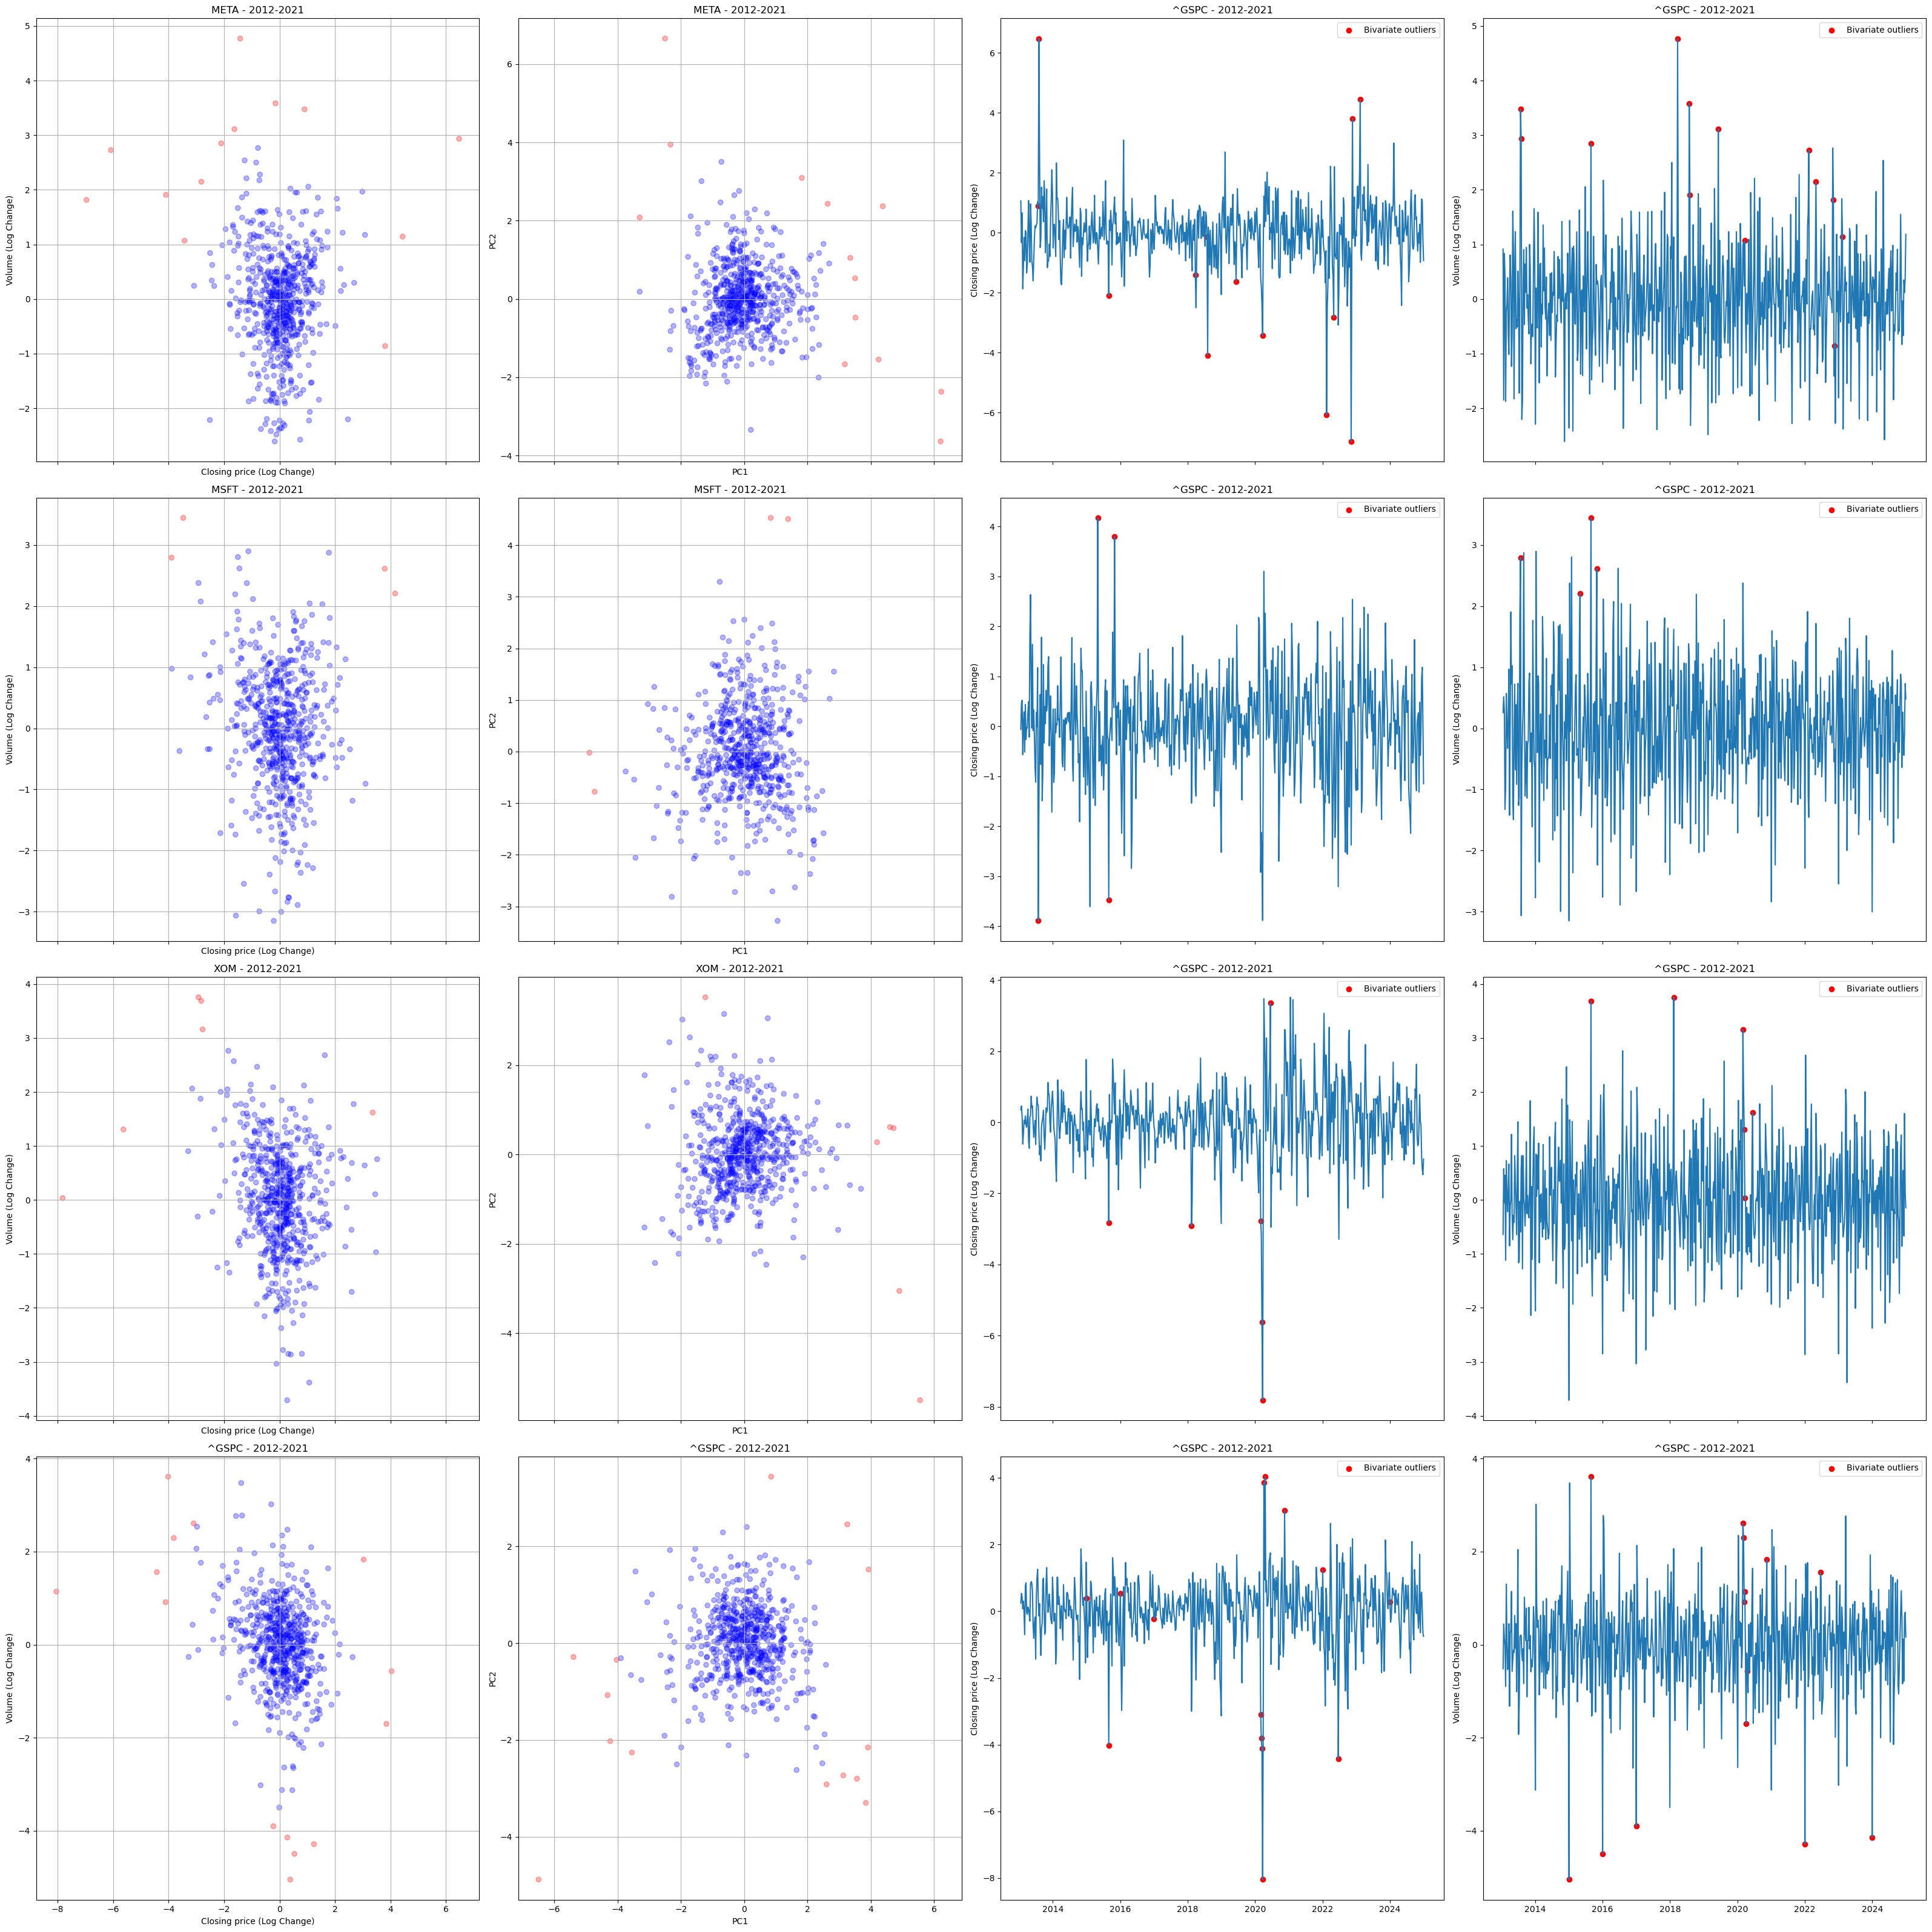

In [432]:
pval_thr = 0.10
anomalies = dict()
fig, axes = plt.subplots(len(symbols),4, figsize=(8*4, 8*4), sharex='col')

for j, s in enumerate(symbols):
    data = log_changes[["Close","Volume"]].loc[:, pd.IndexSlice[:,s]]

    # find PCs
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data-np.median(data, axis=0))

    # calculta background dist
    IQR = np.percentile(pca_data, 75, axis=0) - np.percentile(pca_data, 25, axis=0)
    std = IQR / 1.349
    cov = np.diag(std ** 2)
    mahalanobis_dist = np.sqrt(np.sum(pca_data @ np.linalg.inv(cov) * pca_data, axis=1))

    pvals = 1-ss.chi2.cdf(mahalanobis_dist, df=2)
    # print(pvals)
    chi2_thr = ss.chi2.ppf(1-
        # BH_cutoff(pvals,pval_thr)
        0.10
        ,df=2)
    anomalies[s] = mahalanobis_dist > chi2_thr

    # Plot log changes
    ax = axes[j][0]
    ax.scatter(data.iloc[:,0],data.iloc[:,1], alpha = 0.3, 
        c = np.array(['blue','red'])[1*anomalies[s]] )
    ax.set_title(f"{s} - 2012-2021")
    ax.grid(True)
    ax.set_xlabel("Closing price (Log Change)")
    ax.set_ylabel("Volume (Log Change)")

    # Plot PCs
    ax = axes[j][1]
    ax.scatter(pca_data[:,0],pca_data[:,1], alpha = 0.3, 
        c = np.array(['blue','red'])[1*anomalies[s]] )
    ax.set_title(f"{s} - 2012-2021")
    ax.grid(True)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    # plot log change outliers
    ax = axes[j][2]
    ax.plot(log_changes.index,log_changes["Close"].loc[:,s])
    ax.scatter(log_changes.index[anomalies[s]],log_changes["Close"].loc[anomalies[s],s], color = "red",label = "Bivariate outliers")
    ax.set_ylabel("Closing price (Log Change)")
    ax.set_title(f"{t} - 2012-2021")
    ax.legend()

    # plot log change outliers
    ax = axes[j][3]
    ax.plot(log_changes.index,log_changes["Volume"].loc[:,s])
    ax.scatter(log_changes.index[anomalies[s]],log_changes["Volume"].loc[anomalies[s],s], color = "red",label = "Bivariate outliers")
    ax.set_ylabel("Volume (Log Change)")
    ax.set_title(f"{t} - 2012-2021")
    ax.legend()


plt.tight_layout()
plt.show()

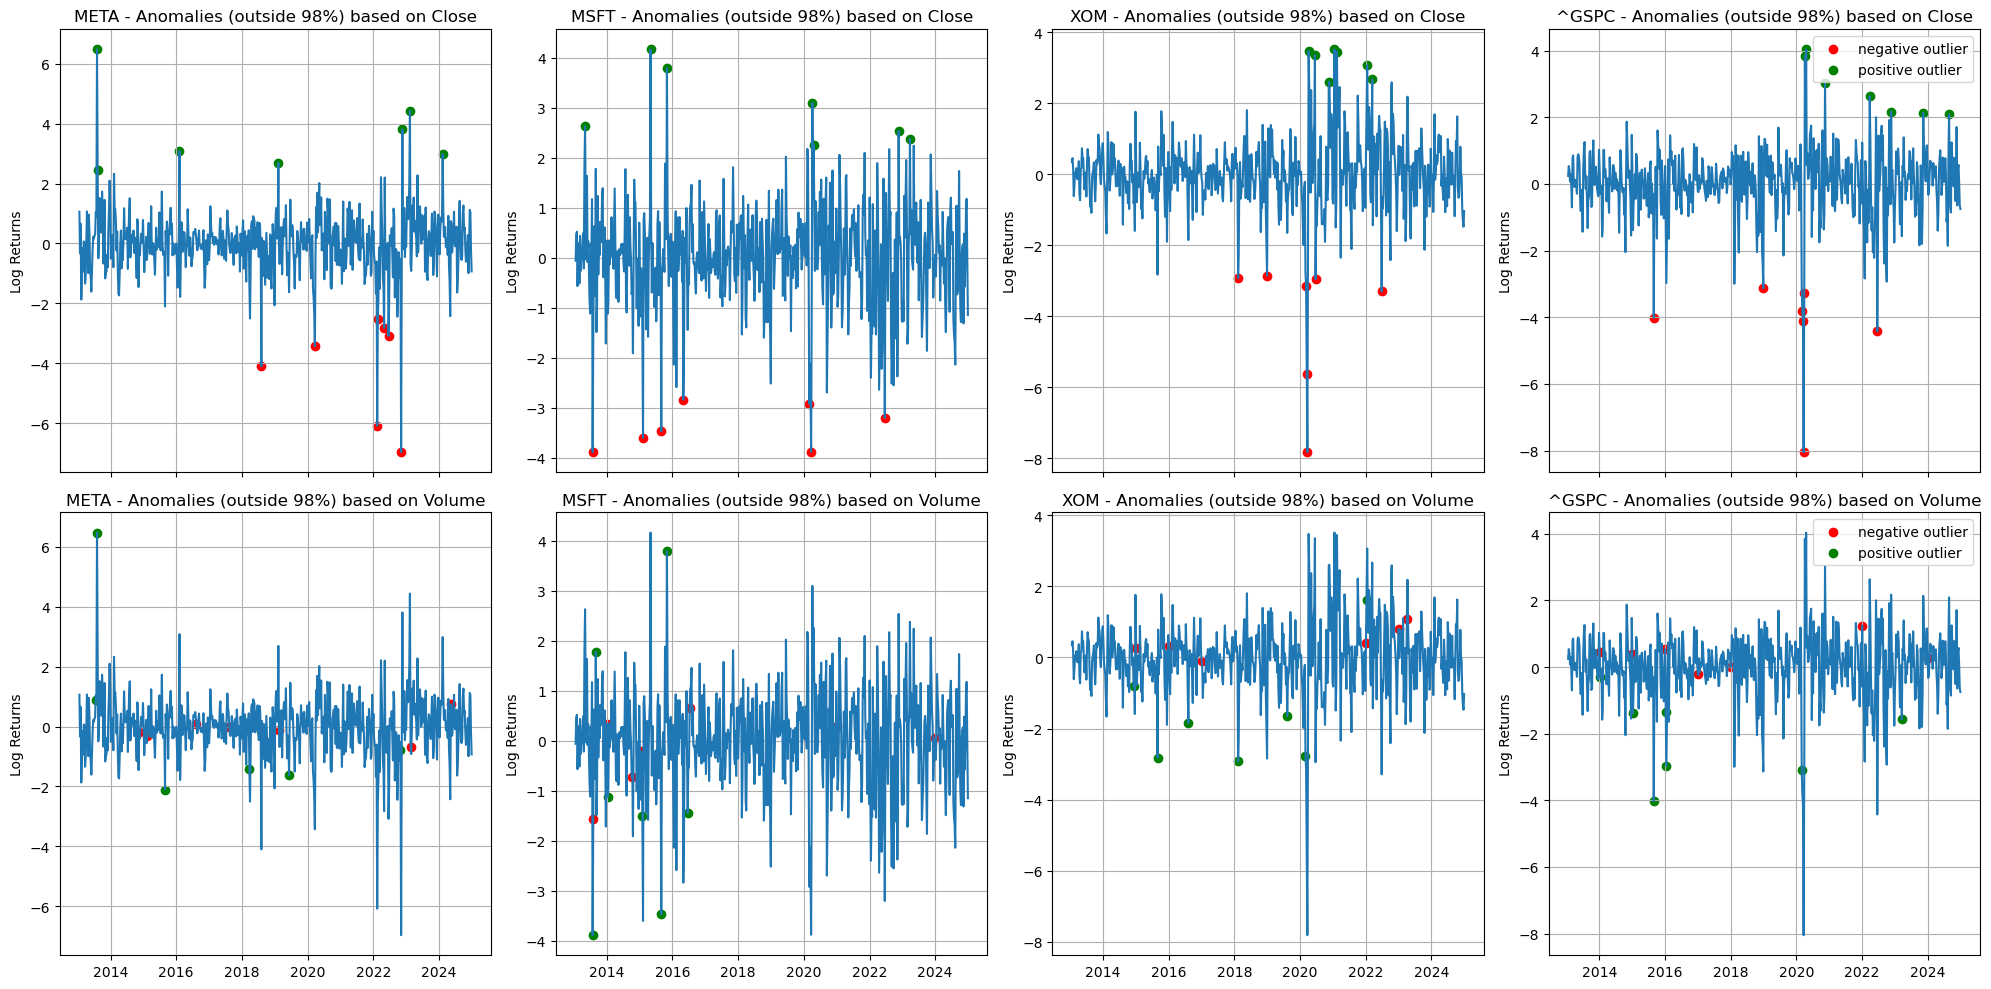

In [145]:
# Anomaly Detection using confidence intervals for each column

weekly_df = weekly_df.loc[log_changes.index]
anom_cols = ["Close","Volume"]
fig, axes = plt.subplots(len(anom_cols), len(symbols), figsize=(5*len(symbols), 5 * len(anom_cols)), sharex=True)

for i,col in enumerate(anom_cols):
    for j,sym in enumerate(symbols):
        ax = axes[i][j]
        low_anomalies = log_changes[col][sym] < np.percentile(log_changes[col][sym],1)
        high_anomalies = log_changes[col][sym] > np.percentile(log_changes[col][sym],99)
        ax.plot(log_changes.index,log_changes["Close"][sym])
        ax.scatter(log_changes.index[low_anomalies],log_changes["Close"][sym].loc[low_anomalies], color = "red",label = "negative outlier")
        ax.scatter(log_changes.index[high_anomalies],log_changes["Close"][sym].loc[high_anomalies], color = "green",label = "positive outlier")
        ax.set_title(f"{sym} - Anomalies (outside 98%) based on {col}")
        ax.set_ylabel("Log Returns")
        ax.grid(True)

    ax.legend()
plt.tight_layout()
plt.show()

Bivariate analysis
- Use PCs 1/rt2,
- Bivaritre dist.
- PC project
- Find outliers using IQR

- test stat = Mahalanobis distance^2, distrib = chi-sq => p-value (Multiple Hyp.)

- Using outisde a certain range (and then adjust the background distribution, might help with multiple correction)
- play with the threshold


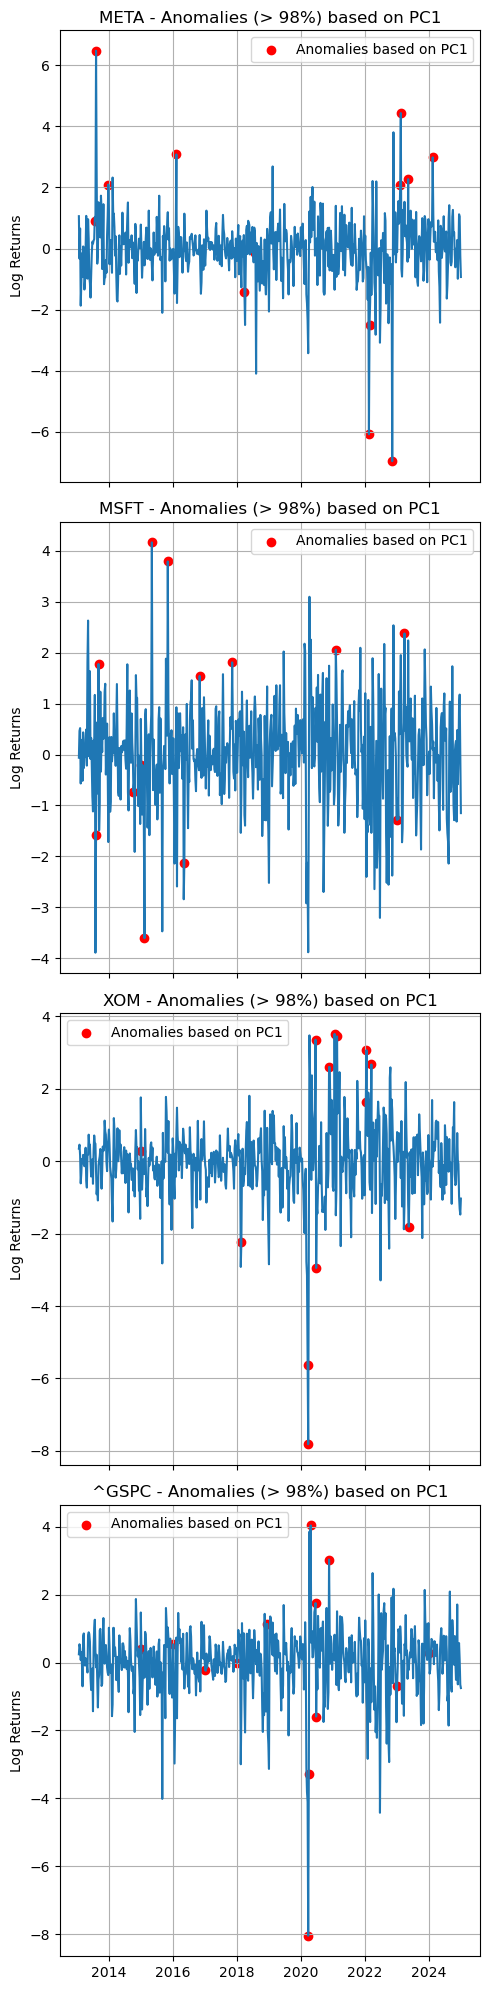

In [146]:
# Anomaly Detection using all columns together using PCA

# Anomaly Detection using confidence intervals for each column

weekly_df = weekly_df.loc[log_changes.index]
anom_cols = ["Close","Volume"]
fig, axes = plt.subplots(len(symbols), figsize=(5, 5*len(symbols)), sharex=True)

for i,sym in enumerate(symbols):
    ax = axes[i]
    
    # Get PCA 
    pca = PCA(n_components = 1)
    actual = log_changes[[(col,sym) for col in cols]]
    pc = pca.fit_transform(actual)

    # Reconstruction
    reconstructed = pca.inverse_transform(pc)
    reconstruction_error = np.sum((actual - reconstructed) ** 2, axis=1)

    # Identify anomalies (e.g., top 2% highest errors)
    threshold = np.percentile(reconstruction_error, 98)
    anomalies = reconstruction_error > threshold


    ax.plot(log_changes.index,log_changes["Close"][sym])
    ax.scatter(log_changes.index[anomalies],log_changes["Close"][sym].loc[anomalies], color = "red",label = "Anomalies based on PC1")
    ax.set_title(f"{sym} - Anomalies (> 98%) based on PC1")
    ax.grid(True)
    ax.set_ylabel("Log Returns")

    ax.legend()
plt.tight_layout()
plt.show()

pca = PCA()



In [121]:
sym = "MSFT"
pc = pca.fit_transform(log_changes[[("Close",sym),("Volume",sym),
# ("Open",sym),("High",sym),("Low",sym)
]])

In [122]:
pca.explained_variance_ratio_

array([0.55294454, 0.44705546])

In [ ]:
pc

In [125]:
cols = ["Close","Volume",
# "Open","High","Low"
]

np.array([[round(pd.DataFrame(log_changes[(col,sym)].values).corrwith(pd.DataFrame(pc[:,pc_i]),axis = 0),3) for pc_i in range(2)] for col in cols])

array([[[ 0.744],
        [ 0.669]],

       [[-0.744],
        [ 0.669]]])

PC1 is correlated with both Close price and Volume, so we sill use it for anomaly detection using percentil 95%

In [136]:
pca = PCA(n_components=1)  # Retain 95% variance
actual = log_changes[[("Close",sym),("Volume",sym)]]
pc = pca.fit_transform(actual)

# Reconstruction
reconstructed = pca.inverse_transform(pc)
reconstruction_error = np.sum((actual - reconstructed) ** 2, axis=1)

# Identify anomalies (e.g., top 5% highest errors)
threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold



In [137]:
reconstruction_error

Date
2013-01-20    0.018948
2013-01-27    0.478806
2013-02-03    0.326035
2013-02-10    1.794258
2013-02-17    0.402886
                ...   
2024-12-01    0.017506
2024-12-08    0.129619
2024-12-15    0.607773
2024-12-22    0.325059
2024-12-29    0.222992
Freq: W-SUN, Length: 624, dtype: float64

In [89]:
log_changes[[("Close","MSFT"),("Volume","MSFT")]]

Price          Close    Volume
Ticker          MSFT      MSFT
Date                          
2013-01-20 -0.061669  0.256338
2013-01-27  0.464552  0.514025
2013-02-03  0.519589  0.287919
2013-02-10 -0.567676 -1.326661
2013-02-17  0.049783 -0.947431
...              ...       ...
2024-12-01 -0.034947 -0.152167
2024-12-08  0.950759 -0.441604
2024-12-15  1.178189 -0.075671
2024-12-22  0.075253  0.731046
2024-12-29 -1.149736  0.481915

[624 rows x 2 columns]